#Multi-Fruit Classification using Convolutional Neural Networks

###Steps for importing Kaggle Dataset into Google Colab

In [ ]:
#!pip install colabcode
#!pip install fastapi

In [ ]:
#from colabcode import ColabCode
#from fastapi import FastAPI

In [ ]:
#cc = ColabCode(port=12000, code=False)

In [ ]:
cc.run_app(app=app)

INFO:     Started server process [145]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "http://1551327d528d.ngrok.io" -> "http://localhost:12000"


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [145]


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!pwd

/content/gdrive/My Drive/Kaggle


In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              224KB  2021-04-24 17:07:26           3525  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2061  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            420  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1322  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip  && rm *.zip

### Importing necessary libraries

In [ ]:

import os, random, math
from pprint import pprint 
from datetime import datetime as dt

import numpy as np
import keras as k
import pickle
import tensorflow as tf


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Globals

In [ ]:
#for reproduceability, each time
SEED = 1337
np.random.seed(SEED)

#fruits to model. Same names as the folders under Training
VALID_FRUITS = ["Apricot","Avocado","Banana","Chestnut","Clementine","Granadilla","Kiwi","Limes",
          "Mango","Maracuja","Peach","Pear","Pomegranate","Raspberry","Pineapple","Strawberry","Walnut"]

# image size width x height
IMG_WIDTH=35
IMG_HEIGHT=35
TARGET_SIZE=[IMG_WIDTH, IMG_HEIGHT]

# RGB = 3 channels
CHANNELS=3

# path to image folders
TRAIN_PATH = "fruits-360/Training"
TEST_PATH = "fruits-360/Test"
PREDICTION_PATH = "for-prediction"

# for batch-wise, memory-efficient iteration
BATCH_SIZE=32
EPOCHS=20


### Image processing

In [ ]:
#Creating data generators using default values, except rescale. 
#Rescaling the pixel values from [0, 255] to [0, 1] interval

train_gen = k.preprocessing.image.ImageDataGenerator(
                                         rotation_range=0.1, 
                                         width_shift_range=0.1, 
                                         height_shift_range=0.1, 
                                         brightness_range=[0.5, 1.5],  
                                         channel_shift_range=0.05, 
                                         rescale=1./255, 
)

test_gen = k.preprocessing.image.ImageDataGenerator(
                                        rotation_range=0.1, 
                                        width_shift_range=0.1, 
                                        height_shift_range=0.1, 
                                        brightness_range=[0.5, 1.5], 
                                        channel_shift_range=0.05, 
                                        rescale=1./255
)


In [ ]:
#create images iterators

train_images_iter = train_gen.flow_from_directory(TRAIN_PATH,                                                            
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS, 
                                                           class_mode = 'categorical',
                                                           seed = SEED)

test_images_iter = test_gen.flow_from_directory(TEST_PATH, 
                                                           target_size = TARGET_SIZE,
                                                           classes = VALID_FRUITS,
                                                           class_mode = 'categorical',
                                                           seed = SEED)

Found 8458 images belonging to 17 classes.
Found 2849 images belonging to 17 classes.


In [ ]:
def get_subplot_grid(mylist, columns, figwidth, figheight):
    plot_rows = math.ceil(len(mylist) / 2.)
    fig, ax = plt.subplots(plot_rows, 2, sharey=True, sharex=False)
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.subplots_adjust(hspace=0.4)
    axflat = ax.flat
    #remove the unused subplot, if any
    for ax in axflat[ax.size - 1:len(mylist) - 1:-1]:
        ax.set_visible(False)

    return fig, axflat

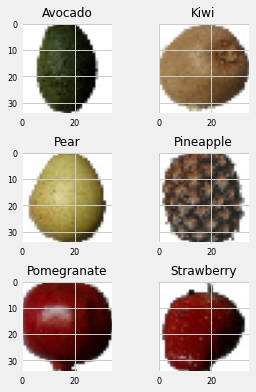

<Figure size 432x288 with 0 Axes>

In [ ]:
test_images_classes = ["Avocado","Kiwi","Pear","Pineapple","Pomegranate","Strawberry"]
test_images=[]

plt.rc('font',family = 'sans-serif',  size=8)
fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)

for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(TRAIN_PATH, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image = k.preprocessing.image.load_img(path=image_file,target_size=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
    #convert to array and resample dividing by 255
    img_array = k.preprocessing.image.img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

In [ ]:
#train_images_iter.class_indices contain the label-index map for each inferred class
#this should match the sort order in VALID_FRUITS
trained_classes_labels = list(train_images_iter.class_indices.keys())
train_images_iter.class_indices

{'Apricot': 0,
 'Avocado': 1,
 'Banana': 2,
 'Chestnut': 3,
 'Clementine': 4,
 'Granadilla': 5,
 'Kiwi': 6,
 'Limes': 7,
 'Mango': 8,
 'Maracuja': 9,
 'Peach': 10,
 'Pear': 11,
 'Pineapple': 14,
 'Pomegranate': 12,
 'Raspberry': 13,
 'Strawberry': 15,
 'Walnut': 16}

In [ ]:
#train_images_iter.classes contains a list of classes of each image
unique, counts = np.unique(train_images_iter.classes, return_counts=True)
print ("number of samples per class")
dict(zip(train_images_iter.class_indices, counts))

number of samples per class


{'Apricot': 492,
 'Avocado': 427,
 'Banana': 490,
 'Chestnut': 450,
 'Clementine': 490,
 'Granadilla': 490,
 'Kiwi': 466,
 'Limes': 490,
 'Mango': 490,
 'Maracuja': 490,
 'Peach': 492,
 'Pear': 492,
 'Pineapple': 490,
 'Pomegranate': 492,
 'Raspberry': 490,
 'Strawberry': 492,
 'Walnut': 735}

In [ ]:
 def build_model():
    #build model
    rtn = k.Sequential()

    # add layers
    # input layer convolution+ReLU
    # padding = 'same' makes the output size equal to the input size
    rtn.add(k.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', strides=(1, 1),
                                    input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS),
                                    kernel_regularizer=k.regularizers.l2(0.0005),
                                    name='conv2d_1'
                                )
                )
    #normalize the output of different activations
    rtn.add(k.layers.BatchNormalization())
    rtn.add(k.layers.Activation('relu', name='activation_conv2d_1'))
    
    # Dropout for 2D feature maps
    rtn.add(k.layers.SpatialDropout2D(0.2))
    
    # hidden conv layer
    rtn.add(k.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', name='conv2d_2'))
    #normalize the output of different activations
    rtn.add(k.layers.BatchNormalization())
    
    #for the dying relu problem, using LeakyRelu
    rtn.add(k.layers.LeakyReLU(0.5, name='activation_conv2d_2'))

    """
    In addition to the function of down-sampling, pooling is used in convolutional neural networks 
    to make the detection of certain features in the input invariant to scale and orientation changes.  
    """
    rtn.add(k.layers.MaxPooling2D(pool_size = (2,2)))
    # randomly switch off 25% of the nodes per epoch step to avoid overfitting
    #rtn.add(k.layers.Dropout(0.25))
    
    # flatten into feature vector
    rtn.add(k.layers.Flatten())
    
    # output features onto a dense layer
    #rtn.add(k.layers.Dense(units = len(trained_classes_labels) * 20, name='dense_1' ) )
    rtn.add(k.layers.Dense(units = 250, name='dense_1' ) )
    rtn.add(k.layers.Activation('relu', name='activation_dense_1'))

    # randomly switch off 50% of the nodes per epoch step to avoid overfitting
    rtn.add(k.layers.Dropout(0.5))

    # output layer with the number of units equal to the number of categories
    rtn.add(k.layers.Dense(units = len(trained_classes_labels), name='dense_2'))
    rtn.add(k.layers.Activation('softmax', name='activation_final'))

    return rtn


my_model = build_model()

### Compile Model

In [ ]:
my_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    #optimizer = k.optimizers.RMSprop(lr = 0.001, decay = 1e-6)
                    optimizer = k.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
                    #optimizer = k.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
                    #optimizer = k.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
                )
#categorical-cross-entropy for a multi-class classification problem,
#From the RMSprop keras docs: This optimizer is usually a good choice for recurrent neural networks.

### Train / Fit

In [ ]:
 #train the model
start = dt.now()
history = my_model.fit_generator(
  # training data
  train_images_iter,

  # epochs
  steps_per_epoch = train_images_iter.n // BATCH_SIZE, #floor per batch size
  epochs = EPOCHS, 

  # validation data
  validation_data = test_images_iter,
  validation_steps = test_images_iter.n // BATCH_SIZE,

  # print progress
  verbose = 1,
  callbacks = [
    #early stopping in case the loss stops decreasing
    k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    # only save the model if the monitored quantity (val_loss or val_acc) has improved
    k.callbacks.ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True),
    # only needed for visualising with TensorBoard
    k.callbacks.TensorBoard(log_dir = "logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()) )
  ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
264/264 [==============================] - 2409s 9s/step - loss: 2.2939 - accuracy: 0.4176 - val_loss: 3.6999 - val_accuracy: 0.3041
Epoch 2/20
264/264 [==============================] - 189s 717ms/step - loss: 0.8705 - accuracy: 0.7127 - val_loss: 0.4938 - val_accuracy: 0.8515
Epoch 3/20
264/264 [==============================] - 189s 714ms/step - loss: 0.5842 - accuracy: 0.8044 - val_loss: 0.2675 - val_accuracy: 0.9182
Epoch 4/20
264/264 [==============================] - 189s 716ms/step - loss: 0.4688 - accuracy: 0.8429 - val_loss: 0.2236 - val_accuracy: 0.9185
Epoch 5/20
264/264 [==============================] - 189s 716ms/step - loss: 0.4167 - accuracy: 0.8571 - val_loss: 0.2051 - val_accuracy: 0.9371
Epoch 6/20
264/264 [==============================] - 187s 710ms/step - loss: 0.3687 - accuracy: 0.8701 - val_loss: 0.1040 - val_accuracy: 0.9680
Epoch 7/20
264/264 [==============================] - 187s 707ms/step - loss: 0.3067 - accuracy: 0.9000 - val_loss: 0.1264 - v

### Plot

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


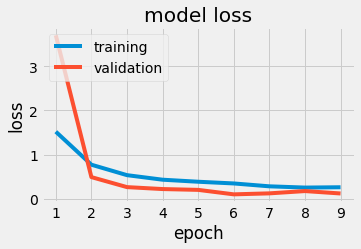

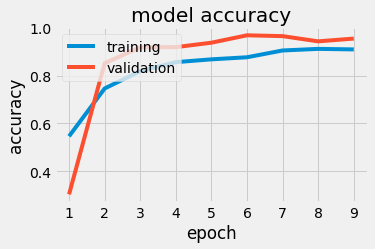

In [ ]:
print(history.history.keys())

plt.style.use('fivethirtyeight')

xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(5,3))
# Loss
#plt.ylim([-0.1,0.5])
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.xticks(xepochs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Accuracy
#plt.ylim([0.7,1.05])
plt.figure(figsize=(5,3))
plt.plot(xepochs, history.history['accuracy'])
plt.plot(xepochs, history.history['val_accuracy'])
plt.xticks(xepochs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
#load model checkpoint
#assumes my_model variable is created and structure is set
my_model=build_model()
# load weights
my_model.load_weights("fruits_checkpoints.h5")
# Compile model (required to make predictions)
my_model.compile(loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'], 
                    optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6)
                )
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [ ]:

my_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 35, 35, 64)        1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 35, 64)        256       
_________________________________________________________________
activation_conv2d_1 (Activat (None, 35, 35, 64)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 35, 35, 128)       512       
_________________________________________________________________
activation_conv2d_2 (LeakyRe (None, 35, 35, 128)      

In [ ]:
my_model.save('./models', save_format='tf') 

INFO:tensorflow:Assets written to: ./models/assets
